<a href="https://colab.research.google.com/github/james-monahan/Code-school-notebooks/blob/main/Week-9-ml-regression/Regression_House_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This is still a work in progress, but complete enough for submission  

#Il s'agit d'un travail encore en cours, mais suffisamment complet pour être soumis

In [ ]:
import pandas as pd
import numpy as np
#import random

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

#To do's:  

>add summary  
>add plot legends, etc


#Objective:  
Fill missing price information based upon predictions using a linear model.  
The model performs an Ordinary least squares Linear Regression and returns the R2 score which is the proportion of the variance in the dependent variable that is predictable from the independent variables. In other words, it measures the difference between real and predicted values. The R2 normally ranges from 0 to 1, with a score of 1 meaning the model perfectly explains the variation from the mean.  

This notebook will solely focus on preprocessing the data and making predictions. EDA and visualizations were conducted prior to this effort. Feature selection and engineering was determined by these prior efforts.

#Summary

I discovered variables that would correlate.  
They would reduce RMSE, but not affect r2.  
Ultimately, simply removing houses where price/sq_foot was outside the 75% percentile resulted in the greatest performance increase.  
I also discovered some mislabeled (likely) data with bedrooms.

###Explanation of special variables:  
'sqft_living15', 'sqft_lot15' represent the avg comparable sq_ft of closest 15 neighboring houses

#Load data

In [ ]:
link = 'https://raw.githubusercontent.com/murpi/wilddata/master/quests/kc_house_data.csv'
df = pd.read_csv(link, parse_dates=['date'])
print("Values to be predicted:")
df[df.isnull().any(axis=1)]

Values to be predicted:


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21609,6600060120,2015-02-23,NaN,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,NaN,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,2014-10-15,NaN,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [ ]:
#Example Extreme Outiler
df.iloc[6994:6995]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6994,2954400190,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061


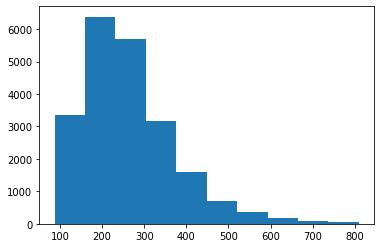

In [ ]:
df_p = df.copy().dropna()
df_p['pricetofoot'] = df['price']//df['sqft_living']
df_p['pricetofoot'].describe()
plt.hist(df_p['pricetofoot'])
plt.show()

In [ ]:
#usually something weird in the results, a data point outside the norm
df_p[df_p['pricetofoot']>600].sample(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricetofoot
20096,3262300485,2015-04-21,2250000.0,5,5.25,3410,8118,2.0,0,0,3,11,3410,0,2006,0,98039,47.6295,-122.236,3410,16236,659.0
9487,6072800205,2014-11-19,2375000.0,4,2.50,3220,20251,1.0,0,0,3,10,3220,0,1969,0,98006,47.5692,-122.192,4200,22114,737.0
3861,1118001295,2014-12-03,2200000.0,4,3.00,3540,11098,2.0,0,0,3,10,3000,540,1940,0,98112,47.6340,-122.288,3430,8214,621.0
11217,8964800695,2015-03-27,1450000.0,3,1.75,2230,13529,1.0,0,0,3,9,2230,0,1949,0,98004,47.6204,-122.217,2230,11900,650.0
6982,824059265,2014-10-01,1155000.0,3,1.75,1640,10464,1.0,0,2,4,8,1640,0,1968,0,98004,47.5873,-122.205,2630,18872,704.0


In [ ]:
df_p[df_p['pricetofoot']>600].groupby('zipcode')['id'].count().nlargest(5)

zipcode
98004    55
98112    23
98039    20
98119    20
98103    17
Name: id, dtype: int64

In [ ]:
#outliers exist in well represented areas
print(df.groupby('zipcode')['id'].count().sort_values(ascending=False)[28:29])
print(df.groupby('zipcode')['id'].count().sort_values(ascending=False)[41:42])

zipcode
98004    317
Name: id, dtype: int64
zipcode
98112    269
Name: id, dtype: int64


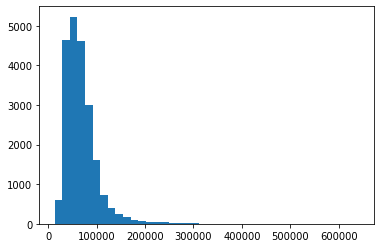

In [ ]:
#grade is also highly correlated
df_p['pricetograde'] = df['price']//df['grade']
plt.hist(df_p['pricetograde'], bins=40)
plt.show()

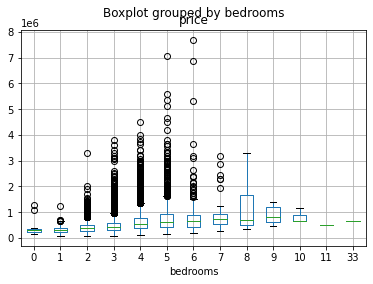

In [ ]:
#price by bedrooms also displays outlier values
df.boxplot('price', by='bedrooms')
plt.show()

#Create a function to make predictions based on a linear model

In [ ]:
def linear_prediction(df_data, X_col, y_pred, normalize = True):
  df = df_data.copy()
  #drop na (data to be predicted)
  X = df.dropna()[X_col]
  y = df.dropna()[y_pred]
  #split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

  model = LinearRegression(normalize= normalize)
  model.fit(X_train, y_train)
  y_prediction = model.predict(X_test)

  print("cols used:", X.columns.values)
  print('rmse:', mean_squared_error(y_test, y_prediction, squared=False))
  print("R2 for train data:", model.score(X_train, y_train))
  print("R2 for test data:", model.score(X_test, y_test))
  print()
  #return preds and test for comparison to determine where model is failing
  return y_test, y_prediction, model

In [ ]:
#establish baseline model
y_pred = 'price'
cols_to_drop = ['price', 'id', 'date']
X_col = df.columns.drop(cols_to_drop)

print("Baseline model:")
linear_prediction(df, X_col, y_pred, normalize = True)

Baseline model:
cols used: ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'zipcode' 'lat' 'long' 'sqft_living15' 'sqft_lot15']
rmse: 209453.11072630956
R2 for train data: 0.7033289164843857
R2 for test data: 0.6909541019052551



(4982     476900.0
 10254    235000.0
 4044     269900.0
 21267    400000.0
 10494    550000.0
            ...   
 20402    437000.0
 11756    435000.0
 85       940000.0
 7708     592500.0
 167      807100.0
 Name: price, Length: 6483, dtype: float64,
 array([363958.7040161 , 129435.84767793, 319092.00837036, ...,
        822016.42576867, 576457.22489942, 729971.4166637 ]),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True))

In [ ]:
# (loop) predict on correlated columns, adding in order of correlation 
build = []
y_pred = 'price'
variables = abs(df.corr()['price']).sort_values(ascending=False).index[1:].drop(['id'])

for item in variables:
  build.append(item)
  linear_prediction(df, build, y_pred)

cols used: ['sqft_living']
rmse: 269724.1330729262
R2 for train data: 0.4953021648921838
R2 for test data: 0.48750578676510237

cols used: ['sqft_living' 'grade']
rmse: 260207.73669540786
R2 for train data: 0.5397328931210399
R2 for test data: 0.5230314271845454

cols used: ['sqft_living' 'grade' 'sqft_above']
rmse: 258604.98317920265
R2 for train data: 0.5465980685122354
R2 for test data: 0.5288891215479612

cols used: ['sqft_living' 'grade' 'sqft_above' 'sqft_living15']
rmse: 258604.72380826794
R2 for train data: 0.5478748825025767
R2 for test data: 0.5288900665599723

cols used: ['sqft_living' 'grade' 'sqft_above' 'sqft_living15' 'bathrooms']
rmse: 257831.01879385777
R2 for train data: 0.549841791693249
R2 for test data: 0.5317048245328333

cols used: ['sqft_living' 'grade' 'sqft_above' 'sqft_living15' 'bathrooms' 'view']
rmse: 247894.16018449445
R2 for train data: 0.5799095799631919
R2 for test data: 0.567105621663489

cols used: ['sqft_living' 'grade' 'sqft_above' 'sqft_living15' 

#Achieving a similar result on fewer variables

In [ ]:
#simplified baseline based on varibales that produced greatest change in R2
y_pred = 'price'
X_col = ['sqft_living', 'grade', 'view', 'lat', 'yr_built']

print("Baseline model:")
b_11, b_22, model = linear_prediction(df, X_col, y_pred, normalize = True)

Baseline model:
cols used: ['sqft_living' 'grade' 'view' 'lat' 'yr_built']
rmse: 219944.58555065922
R2 for train data: 0.6698209146990708
R2 for test data: 0.6592185827595286



In [ ]:
#RMSE comparison to data
print('mean price:',round(df.price.mean()), 'min price:',round(df.price.min()),'max price:',round(df.price.max()))
print('rmse:',219944)

mean price: 540117 min price: 75000 max price: 7700000
rmse: 219944


# Function to perform data cleaning and feature engineering:  

In [ ]:
def clean_and_transform(df_data, lat_long_bins=10, reno_bins=5, drop_engineered=False, drop_orig=False, bedroom_limit = None):
  ### bedroom limit: 'None' uses data as is, '-1' removes col, or set value to limit dataset by num bedrooms ###

  original_cols = df_data.columns.drop(['price'])

  df = df_data.copy()

  #remove duplicates, keeping most recent value (values duplicated as they were relisted at a different price)
  cols_to_check = df.drop(['date', 'price'], axis=1).columns
  df = df.sort_values('date').drop_duplicates(cols_to_check, keep='last').sort_index()

  #add total size (lot and living)
  df['total_size'] = df['sqft_living']+df['sqft_lot']
  
  #add comparison to neighbors size
  df['sqft_living_to_neighbor'] = df['sqft_living']-df['sqft_living15']
  df['sqft_lot_to_neighbor'] = df['sqft_lot']-df['sqft_lot15']

  #add sq_foot per floor
  df['sq_per_floor'] = df['sqft_living']//df['floors']

  #bin lat and long
  data_lat = pd.cut(df['lat'], bins= lat_long_bins, labels= range(1,lat_long_bins+1))
  data_long = pd.cut(df['long'], bins= lat_long_bins, labels= range(1,lat_long_bins+1))
  df['lat_bin'] = data_lat
  df['long_bin'] = data_long
  #planning to convert to feature cross
  df['lat_long_bin'] = (df['lat_bin'].astype('int64')**2) * (df['long_bin'].astype('int64')**2)
  df['lat_long_bin'] = pd.cut(df['lat_long_bin'], bins= lat_long_bins, labels= range(1,lat_long_bins+1))

  #bin renovation
  df_zero = df[df['yr_renovated']==0]
  df_not_zero = df[df['yr_renovated']!=0]
  data_ren = pd.cut(df_not_zero['yr_renovated'], bins=reno_bins, labels= range(1,reno_bins+1))
  df['renovation_binned'] = data_ren  
  df['renovation_binned'] = df['renovation_binned'].cat.add_categories(0)
  df['renovation_binned'].fillna(0, inplace=True)

  #bedroom limit
  if bedroom_limit == -1:
    df = df.drop('bedrooms', axis=1)
  elif bedroom_limit:
    df = df[(df['bedrooms'] <= bedroom_limit)]

  #drop_engineered, remove all engineered cols
  if drop_engineered == True:
    df = df.drop(['total_size', 'sqft_living_to_neighbor', 'sqft_lot_to_neighbor', 'sq_per_floor', 'lat_long_bin', 'long_bin', 'renovation_binned'], axis=1)

  #drop all original columns
  if drop_orig == True:
    df = df.drop(original_cols, axis=1)
  else:
    #drop unneeded columns, sqft_above is redundant
    #drop sq lviing as it is duplicate value (above + basement)
    df = df.drop(['id', 'date', 'zipcode','sqft_living'], axis=1)

  return df

In [ ]:
#using everything
df_new = clean_and_transform(df, lat_long_bins=5, reno_bins=5, drop_engineered=False, drop_orig=False, bedroom_limit = None)

y_pred = 'price'
cols_to_drop = ['price']
X_col = df_new.columns.drop(cols_to_drop)

print("Revised model:")
y_test, y_prediction, model2 = linear_prediction(df_new, X_col, y_pred, normalize = False)

Revised model:
cols used: ['bedrooms' 'bathrooms' 'sqft_lot' 'floors' 'waterfront' 'view'
 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'lat' 'long' 'sqft_living15' 'sqft_lot15' 'total_size'
 'sqft_living_to_neighbor' 'sqft_lot_to_neighbor' 'sq_per_floor' 'lat_bin'
 'long_bin' 'lat_long_bin' 'renovation_binned']
rmse: 195032.45938716343
R2 for train data: 0.703360709428436
R2 for test data: 0.6974534399385659



###While modifications to the data set provide slight improvemnt to RMSE, virtually no improvement is made to R2.  

###As we observe the model explaining approx 70% of the variance, let's remove the top 30% based on price/sq ft and see if the model improves.


In [ ]:
#remove data above 70% of price to foot 
#select quantile
q_val=.7
quantile_data = df_p['pricetofoot'].quantile([q_val]).values[0]
df_p_pred = df_p[df_p['pricetofoot'] < quantile_data].copy()
df_new_q = clean_and_transform(df_p_pred, lat_long_bins=5, reno_bins=5, drop_engineered=False, drop_orig=False, bedroom_limit = None)

y_pred = 'price'
cols_to_drop = ['price', 'pricetofoot', 'pricetograde']
X_col = df_new_q.columns.drop(cols_to_drop)

print("Model")
a, b, model3 = linear_prediction(df_new_q, X_col, y_pred, normalize = False)

Model
cols used: ['bedrooms' 'bathrooms' 'sqft_lot' 'floors' 'waterfront' 'view'
 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'lat' 'long' 'sqft_living15' 'sqft_lot15' 'total_size'
 'sqft_living_to_neighbor' 'sqft_lot_to_neighbor' 'sq_per_floor' 'lat_bin'
 'long_bin' 'lat_long_bin' 'renovation_binned']
rmse: 88094.50804888844
R2 for train data: 0.8357242366393008
R2 for test data: 0.829130888376258



####The model now gains an increase in predictive power. At the beginning I pointed out some values far from the norm. It is demonstrated that these values have a meaningful impact on our model performance. At this stage, I would conclude that the best course of action to increase model performance is to clean and verify existing data at the extremes, then standardize a process for collecting and verifying new data. Without further investigation into the correctness of extreme values we are unable to conclude the current model's true potential.

##Additional functionality to compare predicted and actual values, providing a way to view where the model's predictions are furthest from actual.

In [ ]:
#columns reminder
df_new.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'total_size', 'sqft_living_to_neighbor', 'sqft_lot_to_neighbor',
       'sq_per_floor', 'lat_bin', 'long_bin', 'lat_long_bin',
       'renovation_binned'],
      dtype='object')

In [ ]:
#I plan to add binning feature for continuous cols
def group_by_mean(col_to_compare, all=False, n_largest_val = 1):
  pred_df = df_new.loc[y_test.index]
  pred_df['predictions'] = y_prediction
  round_preds = abs(pred_df['predictions']-pred_df['price'])
  pred_df['difference'] = round_preds
  cols = list(pred_df.columns)
  cols.insert(0, cols.pop(cols.index('predictions')))
  cols.insert(0, cols.pop(cols.index('difference')))
  pred_df = pred_df[cols]
  if all == True:
    return np.round(pred_df.groupby(col_to_compare).difference.mean().sort_values(ascending=False))
  if n_largest_val:
    return np.round(pred_df.groupby(col_to_compare).difference.mean().sort_values(ascending=False))[0:n_largest_val]

In [ ]:
#In general, the higher the grade, the more difficulty in making an accurate prediction
col_to_compare = 'grade'
group_by_mean(col_to_compare, all=False, n_largest_val = 5)


grade
13    1655658.0
12     727488.0
3      475079.0
11     401936.0
10     253201.0
Name: difference, dtype: float64

In [ ]:
#Model does not seem to predict well using year, could be converted to 'age' or bin data by decade
col_to_compare = 'yr_built'
group_by_mean(col_to_compare, all=True, n_largest_val = False)

yr_built
1911    222035.0
1935    204087.0
1928    198886.0
1952    181341.0
2008    176246.0
          ...   
1962     74630.0
1901     73377.0
1913     73154.0
1944     62848.0
1917     53457.0
Name: difference, Length: 116, dtype: float64

##Prediction

In [ ]:
#get data with missing, data is already preprocessed
to_predict = df_new.loc[df_new.price.isna()]

In [ ]:
preds_for_na = model3.predict(to_predict.drop('price', axis=1))

In [ ]:
to_predict.loc[:,'price'] = preds_for_na

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
to_predict

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,total_size,sqft_living_to_neighbor,sqft_lot_to_neighbor,sq_per_floor,lat_bin,long_bin,lat_long_bin,renovation_binned
21609,402972.732844,4,2.50,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200,8123,480,-1387,1155.0,3,1,1,0
21610,222095.682980,2,0.75,1350,2.0,0,0,3,7,1020,0,2009,0,47.5944,-122.299,1020,2007,2370,0,-657,510.0,4,1,1,0
21611,405009.636930,3,2.50,2388,2.0,0,0,3,8,1600,0,2004,0,47.5345,-122.069,1410,1287,3988,190,1101,800.0,4,2,1,0
21612,222607.682980,2,0.75,1076,2.0,0,0,3,7,1020,0,2008,0,47.5941,-122.299,1020,1357,2096,0,-281,510.0,4,1,1,0
